# Deep Learning with Python

## 6.2 Understanding recurrent neural networks

> 理解循环神经网络

之前我们用的全连接网络和卷积神经网络都有是被叫做 feedforward networks (前馈网络) 的。这种网络是无记忆的，也就是说，它们单独处理每个输入，在输入与输入之间没有保存任何状态。在这种网络中，我们要处理时间/文本等序列，就必须把一个完整的序列处理成一个大张量，整个的传到网络中，让模型一次看完整个序列。

这个显然和我们人类阅读、学习文本等信息的方式有所区别。我们不是一眼看完整本书的，我们要一个词一个词地看，眼睛不停移动获取新的数据的同时，记住之前的内容，将新的、旧的内容联系在一起来理解整句话的意思。说抽象一些，我们会保存一个关于所处理内容的内部模型，这个模型根据过去的信息构建，并随着新信息的进入而不断更新。我们都是以这种渐进的方式处理信息的。

按照这种思想，我们又得到一种新的模型，叫做**循环神经网络**(recurrent neural network, RNN)，这网络会遍历处理所有序列元素，并保存一个记录已查看内容相关信息的状态(state)。而在处理下一条序列之时，RNN 状态会被重置。使用 RNN 时，我们仍可以将一个序列整个的输出网络，不过在网络内部，数据不再是直接被整个处理，而是自动对序列元素进行遍历。

![循环网络:带有环的网络](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghgvghuih9j30iy0ict9s.jpg)

为了理解循环神经网络，我们用 Numpy 手写一个玩具版的 RNN 前向传递。考虑处理形状为 `(timesteps, input_features)` 的一条序列，RNN 在 timesteps 上做迭代，将当前 timestep 的 input_features 与前一步得到的状态结合算出这一步的输出，然后将这个输出保存为新的状态供下一步使用。第一步时，没有状态，因此将状态初始化为一个全零向量，称为网络的初始状态。

伪代码：

```python
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

这里的 `f(...)` 其实和我们的 Dense 层比较类似，但这里不仅处理输出，还要同时加入状态的影响。所以它就需要包含 3 个参数：分别作用与输出和状态的矩阵 W、U，以及偏移向量 b:

```python
def f(input_t, state_t):
    return activation(
        dot(W, input_t) + dot(U, state_t) + b
    )
```

画个图来表示这个程序：

![一个简单的 RNN，沿时间展开](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghh2b81pn9j31520j276a.jpg)

下面把它写成真实的代码：

In [22]:
import numpy as np

# 定义各种维度大小
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))

successive_outputs = []

for input_t in inputs:    # input_t: (input_features, )
    output_t = np.tanh(   # output_t: (output_features, )
        np.dot(W, input_t) + np.dot(U, state_t) + b
    )
    successive_outputs.append(output_t)
    
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)  # (timesteps, output_features)

print(successive_outputs[-1].shape)
print(final_output_sequence.shape)


(64,)
(100, 64)


在这里，我们最终输出是一个形状为 (timesteps, output_features) ，是所有 timesteps 的结果拼起来的。但实际上，我们一般只用最后一个结果 `successive_outputs[-1]` 就行了，这个里面已经包含了之前所有步骤的结果，即包含了整个序列的信息。

### Keras 中的循环层

把刚才这个玩具版本再加工一下，让它能接收形状为 `(batch_size, timesteps, input_features)` 的输入，批量去处理，就得到了 keras 中的 `SimpleRNN` 层：

```python
from tensorflow.keras.layers import SimpleRNN
```

这个 SimpleRNN 层和 keras 中的其他循环层都有两种可选的输出模式：

| 输出形状 | 说明 | 使用 |
| --- | --- | --- |
| `(batch_size, timesteps, output_features)` | 输出每个 timestep 输出的完整序列 | return_sequences=True |
| `(batch_size, output_features)` | 只返回每个序列的最终输出 | return_sequences=False (默认) |



In [15]:
# 只返回最后一个时间步的输出

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 返回完整的状态序列

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


如果我们要堆叠使用多个 RNN 层的时候，中间的层必须返回完整的状态序列：

In [18]:
# 堆叠多个 RNN 层，中间层返回完整的状态序列

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))    # 最后一层要最后一个输出就行了
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


接下来，我们尝试用 RNN 再次处理 IMDB 问题。首先，准备数据：

In [19]:
# 准备 IMDB 数据

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_train shape:', input_test.shape)


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_train shape: (25000, 500)


构建并训练网络：

In [20]:
# 用 Embedding 层和 SimpleRNN 层来训练模型

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(input_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 17s 107ms/step - loss: 0.6445 - acc: 0.6106 - val_loss: 0.6140 - val_acc: 0.6676
Epoch 2/10
157/157 [==============================] - 20s 129ms/step - loss: 0.4139 - acc: 0.8219 - val_loss: 0.4147 - val_acc: 0.8194
Epoch 3/10
157/157 [==============================] - 20s 124ms/step - loss: 0.3041 - acc: 0.8779 - val_loss

绘制训练过程看看：

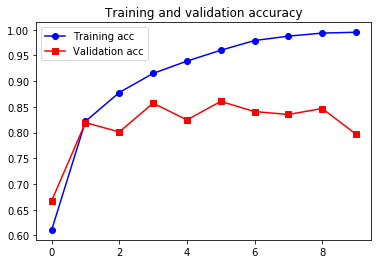

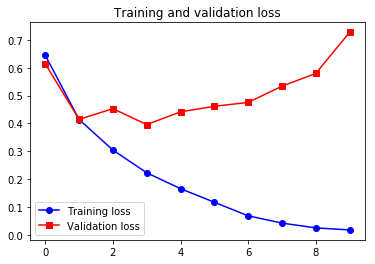

In [21]:
# 绘制结果

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Emmmm，其实吧，这个模型的结果还没有第三章里面的用几个全连接层堆叠起来的模型好。原因有好几个，一个是我们这里只考虑了每个序列的前 500 个单词，还有一个是 SimpleRNN 其实并不擅长处理很长的序列。接下来，我们会看几个能表现的更好的循环层。

#### LSTM 层和 GRU 层

在 Keras 中的循环层，除了 SimpleRNN，还有更“不simple”一些的 LSTM 层和 GRU 层，后面这两种会更常用。

SimpleRNN 是有一些问题的，理论上，在遍历到时间步 t 的时候，它应该是能留存着之前许多步以来见过的信息的，但实际的应用中，由于某种叫做 vanishing gradient problem（梯度消失问题）的现象，它并不能学到这种长期依赖。

梯度消失问题其实在层数比较多的前馈网络里面也会有发生，主要表现就是随着层数多了之后，网络无法训练了。LSTM 层和 GRU 层就是对抗这种问题而生的。

**LSTM** 层是基于 LSTM (长短期记忆，long short-term memory) 算法的，这算法就是专门研究了处理梯度消失问题的。其实它的核心思想就是要保存信息以便后面使用，防止前面得到的信息在后面的处理中逐渐消失。

LSTM 在 SimpleRNN 的基础上，增加了一种跨越多个时间步传递信息的方法。这个新方法做的事情就像一条在序列旁边的辅助传送带，序列中的信息可以在任意位置跳上传送带， 然后被传送到更晚的时间步，并在需要时原封不动地跳回来。


![剖析 LSTM，从 SimpleRNN 到 LSTM:添加一个携带轨道](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghhebke5inj31p80rq78o.jpg)

这里把之前 SimpleRNN 里面的权重 W、U 重命名为 Wo、Uo 了（o 表示 output）。然后加了一个“携带轨道”数据流，这个携带轨道就是用来携带信息跨越时间步的。这个携带轨道上面放着时间步 t 的 ct 信息（c 表示 carry），这些信息将与输入、状态一起进行运算，而影响传递到下一个时间步的状态：

```pythoon
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t_next = i_t * k_t + c_t * f_t
```

关于 LSTM 更多的细节、内部实现就不介绍了。咱完全不需要理解关于 LSTM 单元的具体架构，理解这东西就不是人干的事。我们只需要记住 LSTM 单元的作用: 允许把过去的信息稍后再次拿进来用，从而对抗梯度消失问题。

(P.S. 作者说这里是玄学，信他就行了。🤪 Emmm，这句是我胡翻的，原话是:“it may seem a bit arbitrary, but bear with me.”)

**GRU**，书上就没提，参考这篇 《[人人都能看懂的GRU](https://zhuanlan.zhihu.com/p/32481747)》，说 GRU 大概是 LSTM 的一种变种吧，二者原理区别不大、实际效果上也差不多，但 GRU 比 LSTM 新一些、更容易计算一些。

#### Keras 中使用 LSTM

我们还是继续用之前处理好的的 IMDB 数据来跑一个 LSTM：

In [24]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(input_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 37s 236ms/step - loss: 0.5143 - acc: 0.7509 - val_loss: 0.3383 - val_acc: 0.8672
Epoch 2/10
157/157 [==============================] - 37s 235ms/step - loss: 0.3010 - acc: 0.8834 - val_loss: 0.2817 - val_acc: 0.8862
Epoch 3/10
157/157 [==============================] - 34s 215ms/step - loss: 0.2357 - acc: 0.9129 - val_loss

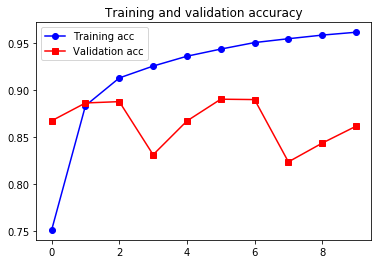

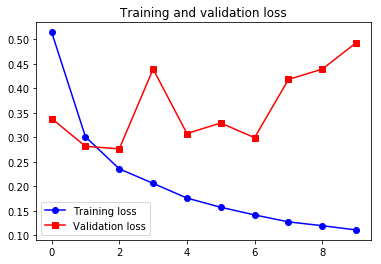

In [25]:
# 绘制结果

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

比 SimpleRNN 好多了。但也没比以前那种用全连接层的网络好多少，而且还比较慢(计算代价大)，其实主要是由于情感分析这样的问题，用 LSTM 去分析全局的长期性结构帮助并不是很大，LSTM 擅长的是更复杂的自然语言处理问题，比如机器翻译。用全连接的方法，其实是做了看出现了哪些词及其出现频率，这个对这种简单问题还比较有效。

然后，我们再试试书上没提的 GRU：

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 37s 238ms/step - loss: 0.5119 - acc: 0.7386 - val_loss: 0.3713 - val_acc: 0.8434
Epoch 2/10
157/157 [==============================] - 36s 232ms/step - loss: 0.2971 - acc: 0.8806 - val_loss: 0.3324 - val_acc: 0.8722
Epoch 3/10
157/157 [==============================] - 37s 235ms/step - loss: 0.2495 - acc: 0.9034 - val_loss

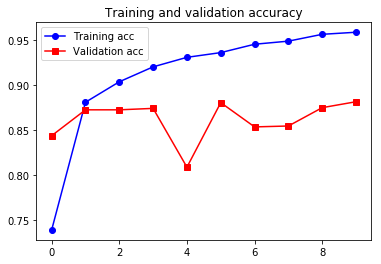

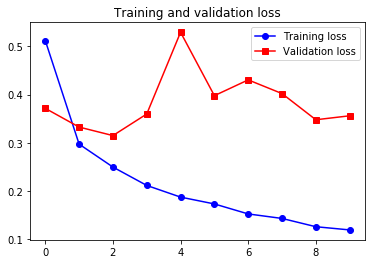

In [26]:
# 把 LSTM 改成用 GRU

from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(input_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

# 绘制结果

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

区别不大。

### 循环神经网络的高级用法

现在，我们通过一个实例，来了解循环神经网络的几个技巧：循环 dropout， 堆叠循环层，双向循环层。

#### 温度预测问题

我们将使用一个气象站记录的天气时间序列数据集，在这个数据集中，有每 10 分钟记录的 14 个量(比如气温、气压、湿度、风向等)，这个数据集里有好多年的记录，这里我们只选用 2009—2016 年的。用这个数据集来构建模型，最后目标是输入最近的一些数据(几天的数据点)，预测未来 24 小时的气温。

首先，下载并解压这个数据集：


```sh
cd ~/Somewhere
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip
```

看一下数据:

In [29]:
import os

data_dir = "/Volumes/WD/Files/dataset/jena_climate"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
print(lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


把数据放到 Numpy 数组中：

In [31]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data.shape)

(420551, 14)
